# Chapter 12 - Exercise Solutions - Applied

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from statsmodels.datasets import get_rdataset
from ISLP import load_data

from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans
from ISLP.cluster import compute_linkage

np.get_printoptions() # 75 default
np.set_printoptions(linewidth=200, precision=4, suppress=True, threshold=10000)

## 7

In this chapter, we mentioned the use of correlation-based distance and Euclidean distance as dissimilarity measures for hierarchical clustering. It turns out that these two measures are almost equivalent: if each observation has been centered to have mean zero and standard deviation one, and if we let $r_{ij}$ denote the correlation between the $i_{th}$ and $j_{th}$ observations, then the quantity $1 − r_{ij}$ is proportional to the squared Euclidean distance between the $i_{th}$ and $j_{th}$ observations.

On the `USArrests` data, show that this proportionality holds.

*Hint:* The Euclidean distance can be calculated using the `pairwise_distances()` function from the `sklearn.metrics` module, and correlations can be calculated using the `np.corrcoef()` function.

In [12]:
USArrests = get_rdataset('USArrests').data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [116]:
scaler = StandardScaler(with_std=True, with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests.T).T # Transpose to normalize across features (not observations)
USArrests_scaled.shape

(50, 4)

In [91]:
corr_matrix = np.corrcoef(USArrests_scaled) # Correlation between observations (rows of x)
corr_matrix

array([[1.        , 0.99092502, 0.99856984, ..., 0.96759749, 0.58753266, 0.98911539],
       [0.99092502, 1.        , 0.98969621, ..., 0.93489972, 0.51058785, 0.96749454],
       [0.99856984, 0.98969621, 1.        , ..., 0.97553899, 0.61849688, 0.99361584],
       ...,
       [0.96759749, 0.93489972, 0.97553899, ..., 1.        , 0.7724072 , 0.99407361],
       [0.58753266, 0.51058785, 0.61849688, ..., 0.7724072 , 1.        , 0.7001675 ],
       [0.98911539, 0.96749454, 0.99361584, ..., 0.99407361, 0.7001675 , 1.        ]])

In [101]:
eucdist_appx = np.sqrt(1 - corr_matrix)
eucdist_appx

array([[1.49011612e-08, 9.52626680e-02, 3.78174278e-02, ..., 1.80006984e-01, 6.42236202e-01, 1.04329324e-01],
       [9.52626680e-02, 1.49011612e-08, 1.01507591e-01, ..., 2.55147560e-01, 6.99579980e-01, 1.80292712e-01],
       [3.78174278e-02, 1.01507591e-01, 1.49011612e-08, ..., 1.56400161e-01, 6.17659386e-01, 7.99009508e-02],
       ...,
       [1.80006984e-01, 2.55147560e-01, 1.56400161e-01, ..., 1.49011612e-08, 4.77066870e-01, 7.69830457e-02],
       [6.42236202e-01, 6.99579980e-01, 6.17659386e-01, ..., 4.77066870e-01, 0.00000000e+00, 5.47569632e-01],
       [1.04329324e-01, 1.80292712e-01, 7.99009508e-02, ..., 7.69830457e-02, 5.47569632e-01, 1.49011612e-08]])

In [102]:
eucdist = pairwise_distances(USArrests_scaled, metric='euclidean')
eucdist

array([[0.        , 0.26944351, 0.10696384, ..., 0.50913664, 1.81651829, 0.29508789],
       [0.26944351, 0.        , 0.28710682, ..., 0.72166628, 1.97871099, 0.5099448 ],
       [0.10696384, 0.28710682, 0.        , ..., 0.44236646, 1.74700456, 0.22599402],
       ...,
       [0.50913664, 0.72166628, 0.44236646, ..., 0.        , 1.34934887, 0.21774093],
       [1.81651829, 1.97871099, 1.74700456, ..., 1.34934887, 0.        , 1.5487608 ],
       [0.29508789, 0.5099448 , 0.22599402, ..., 0.21774093, 1.5487608 , 0.        ]])

In [94]:
eucdist/eucdist_appx

/var/folders/04/x6phf57n2c7d0_05mhjff6cm0000gn/T/ipykernel_47194/2371874435.py:1: RuntimeWarning: invalid value encountered in divide
  eucdist/eucdist_appx


array([[0.        , 2.82842712, 2.82842712, ..., 2.82842712, 2.82842712, 2.82842712],
       [2.82842712, 0.        , 2.82842712, ..., 2.82842712, 2.82842712, 2.82842712],
       [2.82842712, 2.82842712, 0.        , ..., 2.82842712, 2.82842712, 2.82842712],
       ...,
       [2.82842712, 2.82842712, 2.82842712, ..., 0.        , 2.82842712, 2.82842712],
       [2.82842712, 2.82842712, 2.82842712, ..., 2.82842712,        nan, 2.82842712],
       [2.82842712, 2.82842712, 2.82842712, ..., 2.82842712, 2.82842712, 0.        ]])

In [115]:
I = np.identity(USArrests.shape[0])
ones = np.ones((USArrests.shape[0],USArrests.shape[0]))

offset = (( (eucdist + I) / (eucdist_appx + I) ) - I )/2.82842712 + I # Extra Is to avoid div by 0; should me a (n x n) matrix of ones
np.allclose(offset, ones)

True

For this dataset, the proportionality holds; the approximation is offset by a proportional factor of 2.82842712.

## 8

In Section 12.2.3, a formula for calculating PVE was given in Equation 12.10. We also saw that the PVE can be obtained using the `explained_variance_ratio_` attribute of a fitted `PCA()` estimator.

On the `USArrests` data, calculate PVE in two ways:



**(a)** Using the `explained_variance_ratio_` output of the fitted `PCA()` estimator, as was done in Section 12.2.3.

In [133]:
USArrests = get_rdataset('USArrests').data
scaler = StandardScaler(with_std=True, with_mean=True)
X = scaler.fit_transform(USArrests)

In [134]:
pcaUS = PCA()
pcaUS.fit(X)

PCA()

In [135]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

**(b)** By applying Equation 12.10 directly. The loadings are stored as the `components_` attribute of the fitted `PCA()` estimator. Use those loadings in Equation 12.10 to obtain the PVE.

In [136]:
scores = pcaUS.transform(X) # 50x4
loadings = pcaUS.components_ # 4x4 Each row contains a principle componenet loading vector

$$ Z = \phi X $$

In [223]:
PVE = [0] * X.shape[1]

for m in range(0,X.shape[1]):

    num_arr = [0] * X.shape[0]
    for i in range(0,X.shape[0]):

        for j in range(0,X.shape[1]):
            num_arr[i] += loadings[m,j] * X[i,j] # Note dimensions are swapped for loadings[m,j] compared to textbook notation

    num = sum(np.array(num_arr)**2)

    den = 0
    for j in range(0,X.shape[1]):
        for i in range(0,X.shape[0]):
            den += X[i,j]**2

    # den = 

    PVE[m] = num/den
    
np.array(PVE)

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

The results are identical.

Alternatively, using the PCE scores directly...

In [229]:
for m in range(0,X.shape[1]):
    num = np.sum(scores[:,m]**2)
    den = np.sum(X**2)
    print(num/den)

0.6200603947873737
0.24744128813496044
0.08914079514520752
0.04335752193245883


## 9

Consider the `USArrests` data. We will now perform hierarchical clustering on the states.

**(a)** Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.

In [6]:
X = get_rdataset('USArrests').data

In [89]:
X

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


In [7]:
h_clust_complete = AgglomerativeClustering(metric='euclidean', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_complete.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='euclidean', n_clusters=None)

**(b)** Cut the dendrogram at a height that results in three distinct clusters. Which states belong to which clusters?

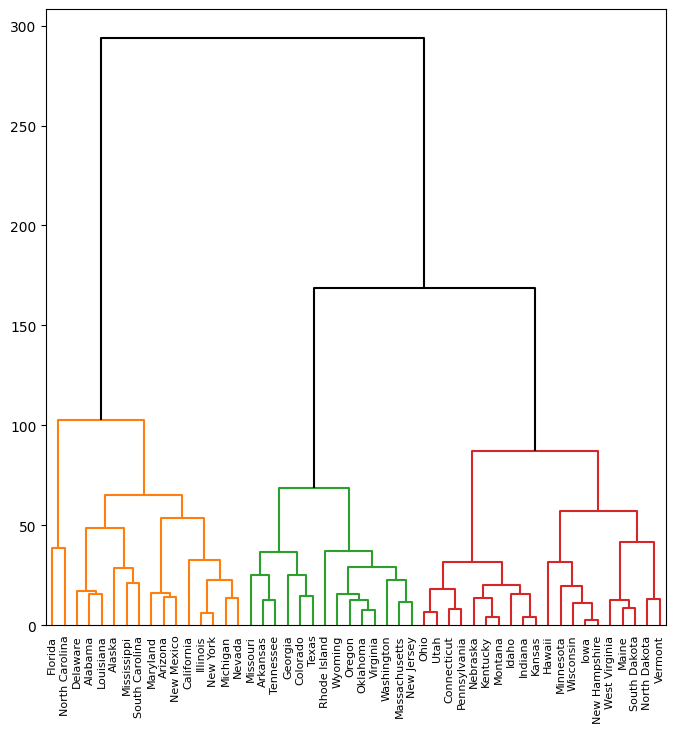

In [33]:
linkage_comp = compute_linkage(h_clust_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           labels=X.index,
           color_threshold=130,
           above_threshold_color='black'
           );

In [9]:
cut_tree(linkage_comp, n_clusters=3).T

array([[0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]])

In [13]:
cut_tree(linkage_comp, height=130).T

array([[0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]])

In [95]:
clusters_df = pd.DataFrame(list(X.index), columns=['state'])
clusters_df['group_no'] = cut_tree(linkage_comp, height=130)
clusters_df.sort_values(by=['group_no','state'], inplace=True)
clusters_df.iloc[0:5,]

,state,group_no
0,Alabama,0
1,Alaska,0
2,Arizona,0
4,California,0
7,Delaware,0


**(c)** Hierarchically cluster the states using complete linkage and Euclidean distance, after scaling the variables to have standard deviation one.

In [84]:
scaler = StandardScaler(with_std=True, with_mean=False)
X_scaled = scaler.fit_transform(X)

In [85]:
h_clust_complete_scaled = AgglomerativeClustering(metric='euclidean', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_complete_scaled.fit(X_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='euclidean', n_clusters=None)

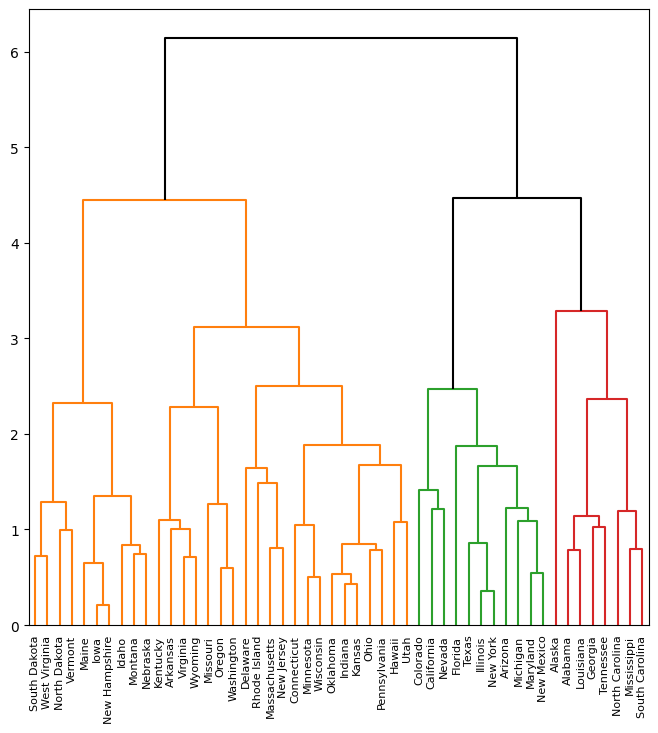

In [86]:
linkage_comp_scaled = compute_linkage(h_clust_complete_scaled)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scaled,
           ax=ax,
           labels=X.index,
           color_threshold=4.45,
           above_threshold_color='black'
           );

**(d)** What effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should the variables be scaled before the inter-observation dissimilarities are computed? Provide a justification for your answer.

Scaling the variables to have a common standard deviation of one has the effect of resulting in one large group,a nd two smaller groups. The unscaled data resulted in three groups of roughly the same size.

We may want to scale the data before clustering if each varible is measured in an arbitrary unit, in which the measures in one variable may dominate the other variables in the clustering algorithm. In this case, `Murder`, `Assault`, and `Rape` are each measured on a per-capital basis (per 100,000 individuals), so these three variables are probablyl fairly comparible without scaling. However, `UrbanPop` is measured as a percentage, and is therefore not conceptually comparable with per-capita counts. The different measurement unit would make scaling more appropriate for these data.

## 10

In this problem, you will generate simulated data, and then perform PCA and $K$-means clustering on the data.

### Generate simulated data

**(a)** Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables.

Hint: There are a number of functions in Python that you can use to generate data. One example is the `normal()` method of the `random()` function in `numpy`; the `uniform()` method is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.

In [31]:
rng = np.random.default_rng(1)
mat = rng.normal(loc=0, scale=2.0, size=(60,50))
mat = mat + np.concatenate(( np.ones((20,50)) * -2, np.ones((20,50)), np.ones((20,50)) * 2 ), axis=0)
# (20,50) +2 avg
# (20,50)
# (20,50) -2 avg

mat_labels = np.concatenate((np.zeros((20)), np.ones((20)), np.ones((20))*2))
mat_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

### PCA

**(b)** Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors.

In [32]:
scaler = StandardScaler(with_std=True, with_mean=True)
mat_scaled = scaler.fit_transform(mat)

In [74]:
pca_mat = PCA()
pca_mat.fit(mat)
scores = pca_mat.transform(mat)

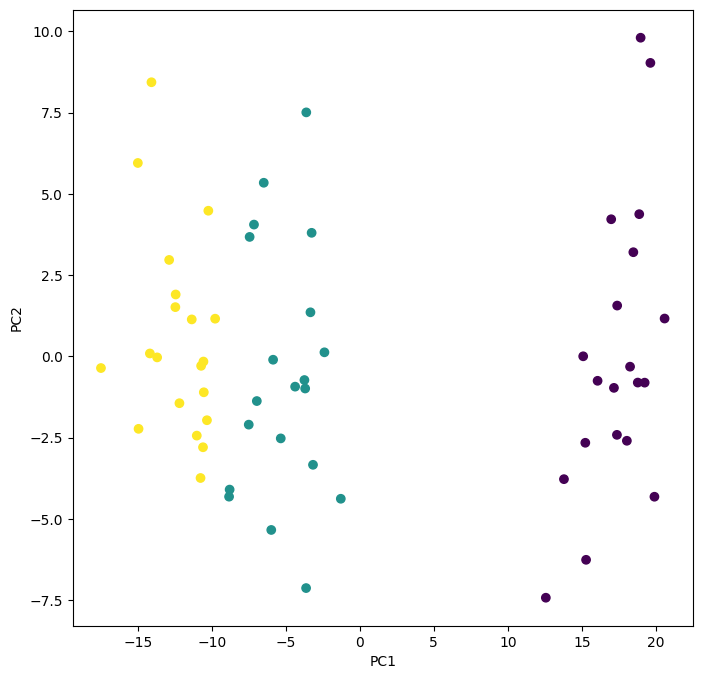

In [75]:
i, j = 0, 1 # (x, y) which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,i], scores[:,j], c=mat_labels)
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1));

The three groups (yellow, green, purple) appear separated along the PC1 dimension.

### *K*-means clustering

**(c)** Perform $K$-means clustering of the observations with $K = 3$. How well do the clusters that you obtained in $K$-means clustering compare to the true class labels?

Hint: You can use the `pd.crosstab()` function in Python to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: $K$-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same.

In [54]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=20).fit(mat) # .fit() operates along axis 0

In [55]:
print(kmeans.labels_[0:20])
print(kmeans.labels_[20:40])
print(kmeans.labels_[40:60])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2]
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0]


In [56]:
pd.crosstab(mat_labels, kmeans.labels_)

col_0,0,1,2
row_0,,,
0.0,0,20,0
1.0,3,0,17
2.0,17,0,3


With particular set of clustering seeds, the "best" final clustering run classifies the observations closely to their true labels: the first class is identifed perfectly, the second and third class *both* have 17 observations identified correctly, and three in the other class.

**(d)** Perform K-means clustering with $K = 2$. Describe your results.

In [59]:
kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init=20).fit(mat)

In [61]:
print(kmeans_2.labels_[0:20])
print(kmeans_2.labels_[20:40])
print(kmeans_2.labels_[40:60])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [62]:
pd.crosstab(mat_labels, kmeans_2.labels_)

col_0,0,1
row_0,,
0.0,20,0
1.0,0,20
2.0,0,20


In $K$-means clustering with two clusters, one cluster is perfectly identified by the first group, and the other two clusters are classified as the second group.

**(e)** Now perform K-means clustering with K = 4, and describe your results.

In [63]:
kmeans_4 = KMeans(n_clusters=4, random_state=0, n_init=20).fit(mat)

In [64]:
print(kmeans_4.labels_[0:20])
print(kmeans_4.labels_[20:40])
print(kmeans_4.labels_[40:60])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 3 2 2 3 2 2 2 2 3 2 2 2 2 0 0 0 2 3]
[0 0 3 0 0 0 3 3 0 0 0 0 3 0 3 0 0 3 0 3]


In [65]:
pd.crosstab(mat_labels, kmeans_4.labels_)

col_0,0,1,2,3
row_0,,,,
0.0,0,20,0,0
1.0,3,0,13,4
2.0,13,0,0,7


In $K$-means clustering with four clusters, one cluster is perfectly identified by the first group (as with $K=2$), a second cluster identifies 13 of 20 in the second classificaton, a third cluster identifes 13 of 20 of the third classification, and the fourth group identifies a combination of the latter two classifications.

### *K*-means on PCA vectors

**(f)** Now perform $K$-means clustering with $K = 3$ on the first two principal component score vectors, rather than on the raw data. That is, perform $K$-means clustering on the $60 \times 2$ matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results.

In [72]:
scores_2 = scores[:,0:2]

In [76]:
kmeans_pca = KMeans(n_clusters=3, random_state=0, n_init=20).fit(scores_2)

In [77]:
print(kmeans_pca.labels_[0:20])
print(kmeans_pca.labels_[20:40])
print(kmeans_pca.labels_[40:60])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [78]:
pd.crosstab(mat_labels, kmeans_pca.labels_)

col_0,0,1,2
row_0,,,
0.0,0,20,0
1.0,20,0,0
2.0,0,0,20


Using the first two PCA components, all observations are perfectly classified with $K=3$ (!)

**(g)** Using the StandardScaler() estimator, perform $K$-means clustering with $K = 3$ on the data after scaling each variable to have standard deviation one. How do these results compare to those obtained in (b)? Explain.

In [79]:
scaler = StandardScaler(with_std=True, with_mean=False)
mat_scaled = scaler.fit_transform(mat)

In [88]:
kmeans_scaled = KMeans(n_clusters=3, random_state=0, n_init=20).fit(mat_scaled)

In [89]:
print(kmeans_scaled.labels_[0:20])
print(kmeans_scaled.labels_[20:40])
print(kmeans_scaled.labels_[40:60])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1]
[2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [90]:
pd.crosstab(mat_labels, kmeans_scaled.labels_)

col_0,0,1,2
row_0,,,
0.0,20,0,0
1.0,0,18,2
2.0,0,1,19


The first classification is identified perfectly; as in other trials, the second two groups have a few errors. However, relataive to **(c)**, accuracy is higher with scaled data. This suggests that measurement units can influence the performance of $K$-means classification.

## 11

Write a Python function to perform matrix completion as in Algorithm 12.1, and as outlined in Section 12.5.2. In each iteration, the function should keep track of the relative error, as well as the iteration count. Iterations should continue until the relative error is small enough or until some maximum number of iterations is reached (set a default value for this maximum number). Furthermore, there should be an option to print out the progress in each iteration.

Test your function on the `Boston` data. First, standardize the features to have mean zero and standard deviation one using the `StandardScaler()` function. Run an experiment where you randomly leave out an increasing (and nested) number of observations from 5% to 30%, in steps of 5%. Apply Algorithm 12.1 with $M = 1,2,...,8$. Display the approximation error as a function of the fraction of observations that are missing, and the value of M, averaged over 10 repetitions of the experiment.

In [97]:
Boston = load_data('Boston')
print(Boston.shape)
Boston.head()

(506, 13)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [96]:
scaler = StandardScaler(with_std=True, with_mean=True)
X = scaler.fit_transform(Boston)
X.shape

(506, 13)

### PCA and SVD comparisons

In [114]:
PCA_X = PCA()
PCA_X.fit(X)
X_scores = PCA_X.transform(X)
X_components = PCA_X.components_

In [105]:
U, D, V = np.linalg.svd(X, full_matrices=False)
U.shape, D.shape, V.shape

((506, 13), (13,), (13, 13))

In [123]:
# Equivalent loading vectors (may differ by sign)
X_components
V

array([[ 0.2428, -0.2544,  0.3392, -0.0034,  0.3313, -0.2106,  0.3053, -0.3059,  0.3055,  0.3275,  0.2138,  0.3173, -0.271 ],
       [-0.0602, -0.1397,  0.1242,  0.4085,  0.2524,  0.4413,  0.2553, -0.3549,  0.0364,  0.0127, -0.3174, -0.2046,  0.4481],
       [ 0.4347,  0.386 , -0.0416, -0.1431, -0.046 ,  0.3446, -0.1946,  0.1476,  0.4822,  0.404 ,  0.0844, -0.1692,  0.1669],
       [ 0.126 ,  0.3217,  0.0023,  0.8162, -0.0004, -0.2732, -0.1217,  0.2113,  0.049 ,  0.0519, -0.1462,  0.1778, -0.1493],
       [-0.1765, -0.3522, -0.0029,  0.3622, -0.2438,  0.1002, -0.1224,  0.0377,  0.1162,  0.0401,  0.7367, -0.255 ,  0.0701],
       [ 0.7571, -0.2958, -0.3476,  0.0843, -0.2058,  0.0906,  0.1134, -0.1005, -0.1487, -0.3294,  0.0124,  0.0818, -0.021 ],
       [ 0.1733, -0.3657,  0.174 , -0.0377,  0.0474, -0.4518, -0.5776, -0.1337,  0.0782,  0.0764, -0.2821, -0.3576,  0.1653],
       [-0.253 , -0.4461, -0.5447,  0.0348,  0.0811,  0.1428, -0.0518,  0.2273,  0.4118,  0.1602, -0.3039,  0.1609, -0

In [128]:
# Equivalent PCA score vectors (may differ by sign)
X_scores
(U * D[None,:])[0:13]

array([[-2.0397,  0.4903, -0.4443, -0.3401, -0.955 ,  0.3182,  0.161 ,  0.4819,  0.0369, -0.7957, -0.1171,  0.491 ,  0.2515],
       [-1.3041, -0.1896, -0.9707, -0.535 ,  0.0791,  0.5794, -0.2947,  0.2309,  0.1542, -0.3078,  0.5918,  0.1161, -0.1128],
       [-2.3402,  0.9145, -0.1132, -1.0956,  0.5481,  0.5177,  0.071 ,  0.0039,  0.2086,  0.0118,  0.4212, -0.3527,  0.0481],
       [-2.8077,  0.1991,  0.0569, -0.9156,  0.977 ,  0.6652,  0.2213,  0.4002,  0.073 , -0.2566,  0.135 , -0.5745,  0.0856],
       [-2.7365,  0.4368,  0.068 , -0.9954,  0.8969,  0.7426, -0.1158,  0.4037, -0.0946, -0.002 ,  0.2275, -0.7754,  0.1442],
       [-2.2578, -0.3352, -0.4506, -0.6174,  0.7229,  0.6805,  0.1235,  0.4197, -0.2402, -0.4874,  0.3373, -0.4254,  0.0189],
       [-1.2484, -0.2313, -0.6853,  0.1854, -1.1582, -0.0094,  0.2871,  0.5858, -0.033 , -0.0796,  0.6034, -0.1393, -0.0632],
       [-0.8564,  0.0831, -0.8638,  0.1347, -1.466 ,  0.184 , -0.7067,  0.6598, -0.5069,  0.3596,  1.0584, -0.6237,  0

### Select missing observations

In [175]:
n_omit = int(X.shape[0] * 0.15) # 5% of observations missing
np.random.seed(15)
r_idx = np.random.choice(np.arange(X.shape[0]), n_omit, replace=False)
c_idx = np.random.choice(np.arange(X.shape[1]), n_omit, replace=True)
X_missing = X.copy()
X_missing[r_idx, c_idx] = np.nan
missing = np.isnan(X_missing)

### Matrix approximation

Initial guess for $X$: starts with column means standing in for missiong values

In [176]:
X_hat = X_missing.copy()
X_bar = np.nanmean(X_hat, axis=0)
X_hat[r_idx, c_idx] = X_bar[c_idx]

Initial MSE

In [177]:
mse_0 = np.mean(X_missing[~missing]**2)
mse_prev = np.mean(X_hat[~missing]**2)

Function to compute a low-rank approximation of a matrix, using firs `M` principal components

In [167]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)  # V is the matrix of loading vectors, dim (p, p)
    L = U[:,:M] * D[None,:M]    # L is the matrix of scores (first M principal components), dim (N, M)
    return L.dot(V[:M])

In [228]:
# This version not nested
def randomize_missing(prop):
    n_omit = int(X.shape[0] * prop) # % of observations missing
    #np.random.seed(15) # We want different seeds each run
    r_idx = np.random.choice(np.arange(X.shape[0]), n_omit, replace=False)
    c_idx = np.random.choice(np.arange(X.shape[1]), n_omit, replace=True)
    X_missing = X.copy()
    X_missing[r_idx, c_idx] = np.nan
    missing = np.isnan(X_missing)

    X_hat = X_missing.copy()
    X_bar = np.nanmean(X_hat, axis=0)
    X_hat[r_idx, c_idx] = X_bar[c_idx]

    mse_0 = np.mean(X_missing[~missing]**2)
    mse_prev = np.mean(X_hat[~missing]**2)

    return X_missing, missing, X_hat, mse_0, mse_prev

Solver

In [197]:
thresh = 1e-7

result_M = []
for M in range(1,9):

    result_pct = []
    for pct in range(5,35,5):
        X_missing, missing, X_hat, mse_0, mse_prev = randomize_missing(pct/100)

        rel_err = 1
        count = 0

        while rel_err > thresh and count < 100:
            
            # Step 2(a): Approximate X_hat using first M principal component scores
            X_appx = low_rank(X_hat, M=1)

            # Step 2(b): Update X_hat missing values with approximated values
            X_hat[missing] = X_appx[missing]

            # Step 2(c): Compute relative error
            mse = np.mean(((X_missing - X_appx)[~missing])**2)
            rel_err = (mse_prev - mse) / mse_0
            mse_prev = mse

            # print(f'Iteration {count}, MSE {mse:0.3f}, Rel Err: {rel_err:0.2e}')

            count += 1

        result_pct.append(mse)

    result_M.append(result_pct)


In [207]:
result_matrix = np.zeros((len(result_M),len(result_M[0])))
for i in range(0,len(result_M)):
    for j in range(0,len(result_M[0])):
        result_matrix[i,j]=result_M[i][j]


In [209]:
print(result_matrix)

[[0.5143 0.5117 0.5154 0.5103 0.5176 0.5121]
 [0.5139 0.5142 0.5148 0.5156 0.5114 0.5145]
 [0.5139 0.5117 0.5153 0.5117 0.5143 0.5098]
 [0.5125 0.5123 0.515  0.5134 0.5069 0.5158]
 [0.5104 0.5135 0.5128 0.513  0.5136 0.5145]
 [0.5138 0.5149 0.5135 0.5107 0.5129 0.5162]
 [0.5143 0.5126 0.5115 0.5151 0.5124 0.5123]
 [0.5139 0.5134 0.5153 0.5141 0.5159 0.5123]]


The approximation error (MSE) does not depend on the number of missing observations or the number of principal component vectors used. This is because by definition the algorithm runs until the relative error is below a certain threshold (1e-7 in this case). No matter the initial conditions, the algorithm will run until the relative error meets this threshold, which will correspond to a particular approximation error (around 0.51 in this case).

## 12

In Section 12.5.2, Algorithm 12.1 was implemented using the `svd()` function from the `np.linalg` module. However, given the connection between the `svd()` function and the `PCA()` estimator highlighted in the lab, we could have instead implemented the algorithm using `PCA()`.

Write a function to implement Algorithm 12.1 that makes use of `PCA()` rather than `svd()`.

### Using `np.linalg`

In [229]:
thresh = 1e-7
M = 13

pct = 10

X_missing, missing, X_hat, mse_0, mse_prev = randomize_missing(pct/100)

rel_err = 1
count = 0

while rel_err > thresh and count < 100:
    
    # Step 2(a): Approximate X_hat using first M principal component scores
    X_appx = low_rank(X_hat, M=1)

    # Step 2(b): Update X_hat missing values with approximated values
    X_hat[missing] = X_appx[missing]

    # Step 2(c): Compute relative error
    mse = np.mean(((X_missing - X_appx)[~missing])**2)
    rel_err = (mse_prev - mse) / mse_0
    mse_prev = mse

    print(f'Iteration {count}, MSE {mse:0.3f}, Rel Err: {rel_err:0.2e}')

    count += 1

Iteration 0, MSE 0.516, Rel Err: 4.86e-01
Iteration 1, MSE 0.516, Rel Err: 2.97e-04
Iteration 2, MSE 0.516, Rel Err: 3.46e-06
Iteration 3, MSE 0.516, Rel Err: 4.95e-08


### Using `PCA()`

In [211]:
def low_rank_pca(X, M=1):
    PCA_X = PCA()
    PCA_X.fit(X)
    X_scores = PCA_X.transform(X) # same as (U * D[None,:])[:,0:M]
    V = PCA_X.components_  # same as V
    L = X_scores[0:,0:M]
    return L.dot(V[:M])

In [230]:
thresh = 1e-7
M = 13
pct = 10

X_missing, missing, X_hat, mse_0, mse_prev = randomize_missing(pct/100)

rel_err = 1
count = 0

while rel_err > thresh and count < 100:
    
    # Step 2(a): Approximate X_hat using first M principal component scores
    X_appx = low_rank_pca(X_hat, M=1)

    # Step 2(b): Update X_hat missing values with approximated values
    X_hat[missing] = X_appx[missing]

    # Step 2(c): Compute relative error
    mse = np.mean(((X_missing - X_appx)[~missing])**2)
    rel_err = (mse_prev - mse) / mse_0
    mse_prev = mse

    print(f'Iteration {count}, MSE {mse:0.3f}, Rel Err: {rel_err:0.2e}')

    count += 1

Iteration 0, MSE 0.516, Rel Err: 4.86e-01
Iteration 1, MSE 0.516, Rel Err: 2.97e-04
Iteration 2, MSE 0.516, Rel Err: 3.46e-06
Iteration 3, MSE 0.516, Rel Err: 4.95e-08


When setting the random seed to be identical (in the function `randomize_missing()` above), we see that we get exactly the same MSE and relative error in the same iterations, when compraring `np.linalg` and `PCA()`.

## 13

On the book website, www.statlearning.com, there is a gene expres-sion data set (`Ch12Ex13.csv`) that consists of 40 tissue samples with measurements on 1,000 genes. The first 20 samples are from healthy patients, while the second 20 are from a diseased group.

**(a)** Load in the data using `pd.read_csv()`. You will need to select `header = None`.

In [315]:
gene_df = pd.read_csv('Data/Ch12Ex13.csv', header=None).T
gene_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.961933,-0.292526,0.258788,-1.152132,0.195783,0.030124,0.085418,1.116610,-1.218857,1.267369,...,1.325041,-0.116171,-1.470146,-0.379272,-1.465006,1.075148,-1.226125,-3.056328,1.450658,0.717977
1,0.441803,-1.139267,-0.972845,-2.213168,0.593306,-0.691014,-1.113054,1.341700,-1.277279,-0.918349,...,0.740838,-0.162392,-0.633375,-0.895521,2.034465,3.003267,-0.501702,0.449889,1.310348,0.763482
2,-0.975005,0.195837,0.588486,-0.861525,0.282992,-0.403426,-0.677969,0.103278,-0.558925,-1.253500,...,-0.435533,-0.235912,1.446660,-1.127459,0.440849,-0.123441,-0.717430,1.880362,0.383837,0.313576
3,1.417504,-1.281121,-0.800258,0.630925,0.247147,-0.729859,-0.562929,0.390963,-1.344493,-1.067114,...,-3.065529,1.597294,0.737478,-0.631248,-0.530442,-1.036740,-0.169113,-0.742841,-0.408860,-0.326473
4,0.818815,-0.251439,-1.820398,0.951772,1.978668,-0.364099,0.938194,-1.927491,1.159115,-0.240638,...,-2.378938,-0.086946,-0.122342,1.418029,1.075337,-1.270604,0.599530,2.238346,-0.471111,-0.158700


**(b)** Apply hierarchical clustering to the samples using correlation-based distance, and plot the dendrogram. Do the genes separate the samples into the two groups? Do your results depend on the type of linkage used?

### H-clust: unscaled, correlative dissimilarity, complete linkage

In [316]:
corr_dissimilarity = 1 - np.corrcoef(gene_df)

In [317]:
h_clust_gene_complete = AgglomerativeClustering(metric='precomputed', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_gene_complete.fit(corr_dissimilarity)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

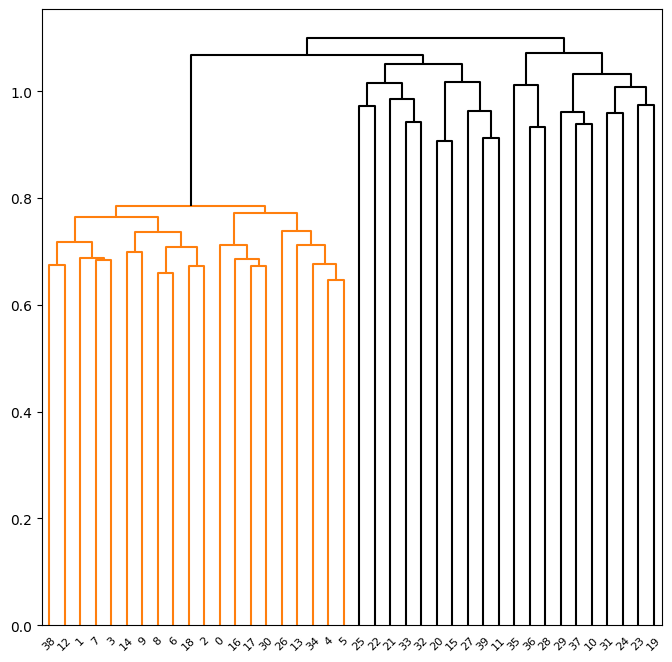

In [318]:
linkage_comp = compute_linkage(h_clust_gene_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           labels=h_clust_gene_complete.labels_,
           color_threshold=0.8,
           above_threshold_color='black'
           );

In [319]:
h_clust_gene_complete.labels_

array([35, 25, 29, 37, 20, 23, 33, 31, 32, 39, 36, 19, 27, 24, 28, 21, 15, 11, 22, 10, 17, 30, 14, 38, 26, 13, 18,  8,  9, 12, 34,  6,  4,  5, 16,  2,  7,  3,  1,  0])

In [320]:
cut_tree(linkage_comp, height=1.08).T

array([[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [321]:
cut_tree(linkage_comp, n_clusters=2).T

array([[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [322]:
clusters_df = pd.DataFrame(h_clust_gene_complete.labels_, columns=['gene_id'])
clusters_df['hclust_group'] = cut_tree(linkage_comp, n_clusters=2)
clusters_df.sort_values(by=['gene_id'], inplace=True)
clusters_df['true_group'] = np.concatenate((np.ones(20),np.zeros(20)), axis=0)
clusters_df.head()

,gene_id,hclust_group,true_group
39,0,1,1.0
38,1,1,1.0
35,2,1,1.0
37,3,1,1.0
32,4,1,1.0


In [323]:
pd.crosstab(clusters_df['true_group'], clusters_df['hclust_group'])

hclust_group,0,1
true_group,,
0.0,8,12
1.0,2,18


With unscaled data, the classification has poor results, with 14 of 40 misclassified observations in total.

### H-clust: scaled, correlative dissimilarity, complete linkage

In [324]:
scaler = StandardScaler(with_std=True, with_mean=True)
gene_scaled = scaler.fit_transform(gene_df)

In [325]:
corr_dissimilarity_scaled = 1 - np.corrcoef(gene_scaled)

In [326]:
h_clust_gene_scaled_complete = AgglomerativeClustering(metric='precomputed', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_gene_scaled_complete.fit(corr_dissimilarity_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

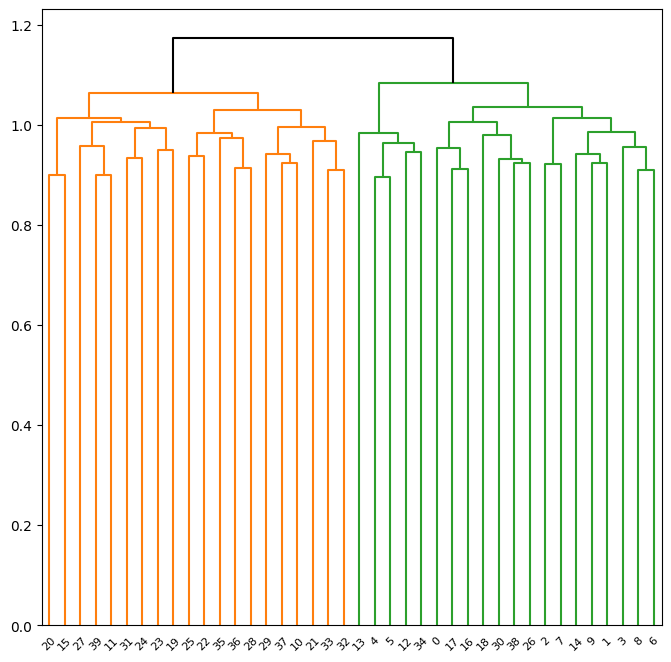

In [327]:
linkage_comp = compute_linkage(h_clust_gene_scaled_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           labels=h_clust_gene_complete.labels_,
           color_threshold=1.1,
           above_threshold_color='black'
           );

In [328]:
cut_tree(linkage_comp, n_clusters=2).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [329]:
clusters_df = pd.DataFrame(h_clust_gene_complete.labels_, columns=['gene_id'])
clusters_df['hclust_group'] = cut_tree(linkage_comp, n_clusters=2)
clusters_df.sort_values(by=['gene_id'], inplace=True)
clusters_df['true_group'] = np.concatenate((np.ones(20),np.zeros(20)), axis=0)
clusters_df.head()

,gene_id,hclust_group,true_group
39,0,1,1.0
38,1,1,1.0
35,2,1,1.0
37,3,1,1.0
32,4,1,1.0


In [330]:
pd.crosstab(clusters_df['true_group'], clusters_df['hclust_group'])

hclust_group,0,1
true_group,,
0.0,16,4
1.0,4,16


With scaled data, the cluserting performs better, with 8 of 40 misclassified genees -- 4 in each of the two groups.

### H-clust: scaled, correlative dissimilarity, single linkage

In [331]:
h_clust_gene_scaled_complete = AgglomerativeClustering(metric='precomputed', distance_threshold=0, n_clusters=None, linkage='single')
h_clust_gene_scaled_complete.fit(corr_dissimilarity_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

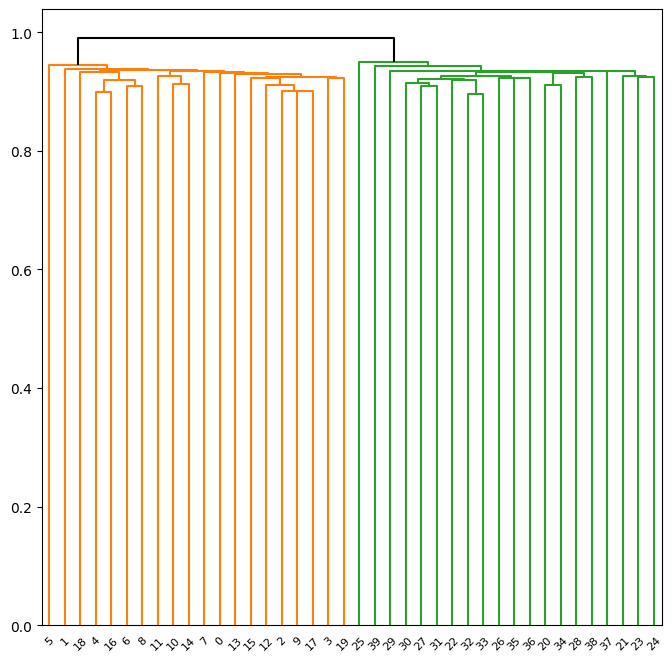

In [332]:
linkage_comp = compute_linkage(h_clust_gene_scaled_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           labels=gene_df.index,
           color_threshold=0.97,
           above_threshold_color='black'
           );

In [333]:
cut_tree(linkage_comp, n_clusters=2).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [334]:
clusters_df = pd.DataFrame(h_clust_gene_complete.labels_, columns=['gene_id'])
clusters_df['hclust_group'] = cut_tree(linkage_comp, n_clusters=2)
clusters_df.sort_values(by=['gene_id'], inplace=True)
clusters_df['true_group'] = np.concatenate((np.ones(20),np.zeros(20)), axis=0)
clusters_df.head()

,gene_id,hclust_group,true_group
39,0,1,1.0
38,1,1,1.0
35,2,1,1.0
37,3,1,1.0
32,4,1,1.0


In [335]:
pd.crosstab(clusters_df['true_group'], clusters_df['hclust_group'])

hclust_group,0,1
true_group,,
0.0,16,4
1.0,4,16


When using scaled data and correlative dissimilarity, the results for complete and single linkage are identical.

**(c)** Your collaborator wants to know which genes differ the most across the two groups. Suggest a way to answer this question, and apply it here.

The answer will depend on what "differing across groups" exactly means. One interpretation could be which genes are most representative of the two groups, as they are defined by the clustering algorithm. Practically, this means the first genes to "join" a cluster in the dendrogram; that is, those with the lowest merge level in the dendrogram plot.

Returning to the dendorgram for scaled data, using complete linkage:

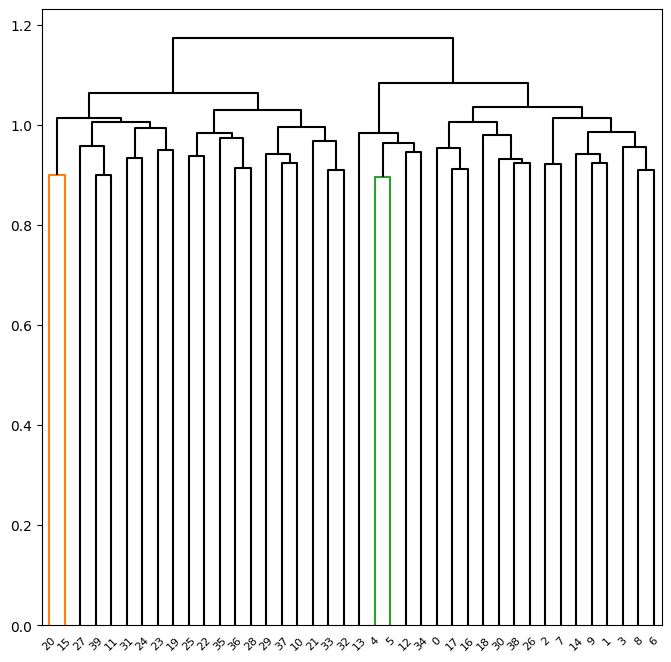

In [336]:
h_clust_gene_scaled_complete = AgglomerativeClustering(metric='precomputed', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_gene_scaled_complete.fit(corr_dissimilarity_scaled)

linkage_comp = compute_linkage(h_clust_gene_scaled_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           labels=h_clust_gene_complete.labels_,
           color_threshold=0.9,
           above_threshold_color='black'
           );

We can see the the first genes merge at around a height of 0.9.

Genes 20 and 15 merge into one group, and genes 4 and 5 merge into another.

In [338]:
cut_tree(linkage_comp, height=0.90).T

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  4, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 31, 32, 33, 34, 35, 36, 37]])

In [353]:
clusters_df = pd.DataFrame(h_clust_gene_complete.labels_, columns=['gene_id'])
clusters_df['hclust_group'] = cut_tree(linkage_comp, height=0.90)
clusters_df.sort_values(by=['gene_id'], inplace=True)
clusters_df['true_group'] = np.concatenate((np.ones(20),np.zeros(20)), axis=0)
clusters_df.iloc[ [15,20,4,5] ,:]

,gene_id,hclust_group,true_group
16,15,4,1.0
4,20,4,0.0
32,4,31,1.0
33,5,31,1.0
